# Cluster analysis to determine countries in need of financial aid

# Table of Contents

* [About the dataset](#about)
     * [Description](#description)
     * [Data exploration](#exploration)
* [Pre-processing](#processing)
* [Data visualization](#visualization)
* [Dimensionality reduction (PCA)](#pca)
     * [Scaling](#scaling)
     * [Normalization](#norm)
* [K-means clustering](#ml)

<a id="about" ></a>
# About dataset

We will cluster countries using socio, economic and health factors (based on numerical features) in order to allocate funding for country's development. This considers unsupervised learning.

<a id="description" ></a>
# Description

## Features
- country : Name of the country
- child_mort : Death of children under 5 years of age per 1000 live births
- exports : Exports of goods and services per capita. Given as %age of the GDP per capita
- health : Total health spending per capita. Given as %age of GDP per capita
- imports : Imports of goods and services per capita. Given as %age of the GDP per capita
- Income : Net income per person
- Inflation : The measurement of the annual growth rate of the Total GDP
- life_expec : The average number of years a new born child would live if the current mortality patterns are to remain the same
- total_fer : The number of children that would be born to each woman if the current age-fertility rates remain the same
- gdpp : The GDP per capita. Calculated as the Total GDP divided by the total population.

<a id="exploration" ></a>
# Data exploration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

countries = pd.read_csv('../input/unsupervised-learning-on-country-data/Country-data.csv')
countries.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [2]:
print("Shape: ", countries.shape, '\n'*2)
print("Columns: ", countries.columns, '\n'*2)

print("Information: ")
print(countries.info(), '\n'*2)

print("Description: ")
print(countries.describe())

Shape:  (167, 10) 


Columns:  Index(['country', 'child_mort', 'exports', 'health', 'imports', 'income',
       'inflation', 'life_expec', 'total_fer', 'gdpp'],
      dtype='object') 


Information: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB
None 


Description: 
       child_mort     exports      health     imports         income  \
count  167.000000  167.000000  167.000000  167

- The mean values are generally > the mean (50%), which means that the **distribution** of the data might be **positively skewed** (tail on the right side).

- The **IQR**, which is the spread of the middle 50% of data (calculated as the **difference between the 75th percentile (Q3) and the 25th percentile (Q1)**), suggests that there is a greater spread of values in the upper quartile of the distribution compared to the lower quartile (Q3 > Q1). In other words, **the data points are more densely concentrated towards the lower end of the range**, with a longer tail extending towards higher values (pattern typical of positively skewed distributions).

- **Outliers** often fall below **Q1 - 1.5 * IQR**, or above **Q3 + 1.5 * IQR**; there are values outside this range, which might be considered outliers; outliers are also identifiable because of the much larger values present (for eg. the max value) than the 75th percentile.

### Check for null values and duplicates

In [3]:
print("NULL VALUES: ", countries.isnull().sum(), '\n'*2)

print("DUPLICATES VALUES: ", countries.duplicated().sum())

NULL VALUES:  country       0
child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64 


DUPLICATES VALUES:  0


<Axes: >

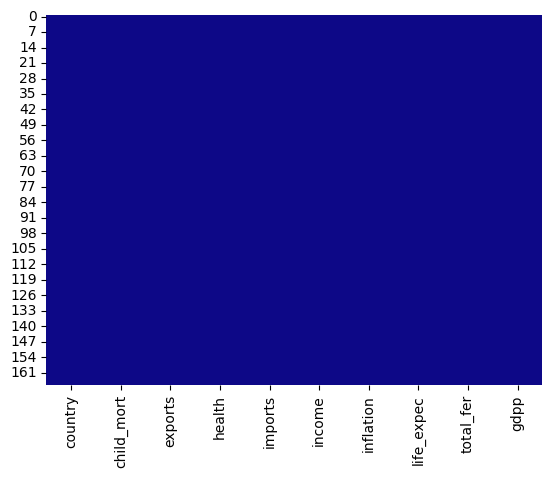

In [4]:
sns.heatmap(countries.isnull(), cmap = 'plasma', cbar = False) # I also removed color bar 

# potential values for cmap
# viridis, plasma, inferno, magma, coolwarm, jet, Greens, Blues, Reds, cividis

> There are no null values and duplicates.

In [5]:
columns = list(countries.columns)
columns.remove('country')

categorical_columns = ['country']
numerical_columns = [*columns] # create a list with all the remaining columns

# print the unpacked elements of the lists as separate arguments:
print('Categorical features: ', *categorical_columns)

# pass each element of numerical_columns list as a separate argument to the print() function
print('Numerical features: ', *numerical_columns)

Categorical features:  country
Numerical features:  child_mort exports health imports income inflation life_expec total_fer gdpp


### Correlation plot

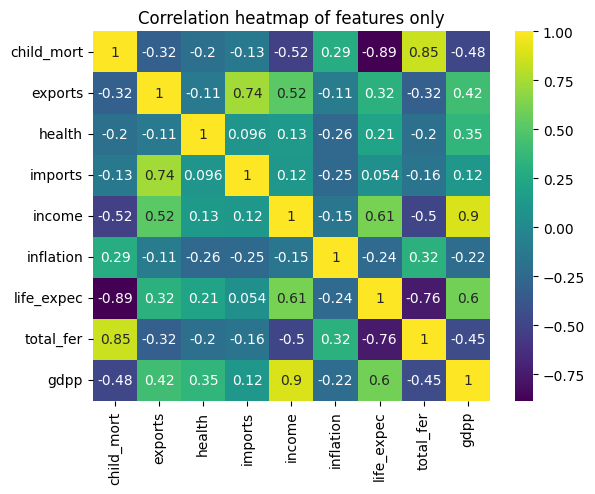

In [6]:
corr_matrix = countries.drop(columns = ['country']).corr()
sns.heatmap(corr_matrix, annot = True, cmap = 'viridis')

plt.title('Correlation heatmap of features only')
plt.show()

- High positive correlations between total fertility (the number of children that would be born to each woman if the current age-fertility rates remain the same) & child mortality (death of children under 5 years of age per 1000 live births), income & exports, the GDP per capita & income, life expectancy & income.
- There is also a slight positive correlation between the income and the child mortality.

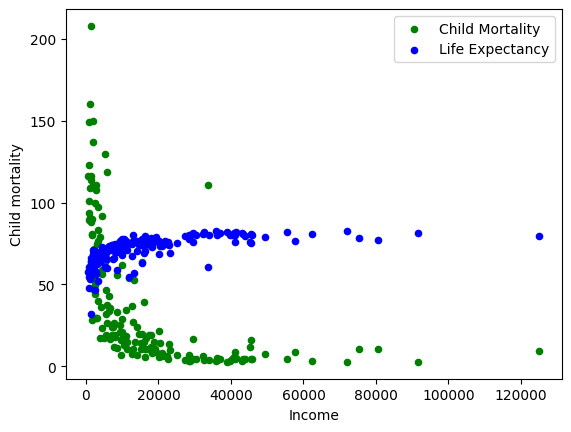

In [7]:
ax1 = countries.plot(kind = 'scatter', x = 'income', y = 'child_mort', color = 'g')
ax2 = countries.plot(kind = 'scatter', x = 'income', y = 'life_expec', color = 'b', ax = ax1) # ax = ax1 because the 2nd plot should be drawn on the same axis

plt.legend(labels = ['Child Mortality', 'Life Expectancy'])
plt.xlabel('Income') 
plt.ylabel('Child mortality') 
# ax1.legend()

plt.show()

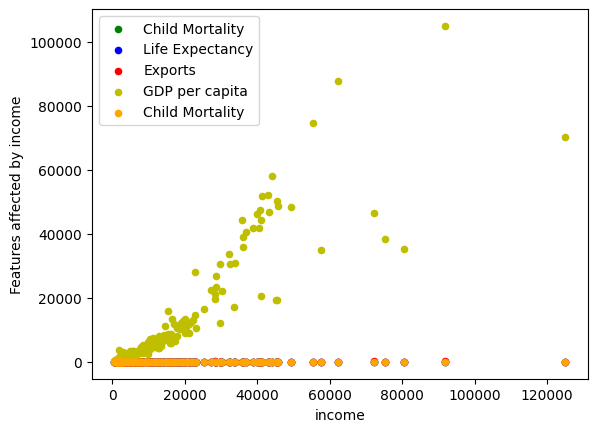

In [8]:
ax = countries.plot(kind = 'scatter', x = 'income', y = 'child_mort', color = 'g', label = 'Child Mortality')
countries.plot(kind = 'scatter', x = 'income', y = 'life_expec', color = 'b', label = 'Life Expectancy', ax = ax)
countries.plot(kind = 'scatter', x = 'income', y = 'exports', color = 'r', label = 'Exports', ax = ax)
countries.plot(kind = 'scatter', x = 'income', y = 'gdpp', color = 'y', label = 'GDP per capita', ax = ax)
countries.plot(kind = 'scatter', x = 'income', y = 'child_mort', color = 'orange', label = 'Child Mortality', ax = ax)

plt.ylabel('Features affected by income')
plt.legend()
plt.show()

### Data distribution across countries

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

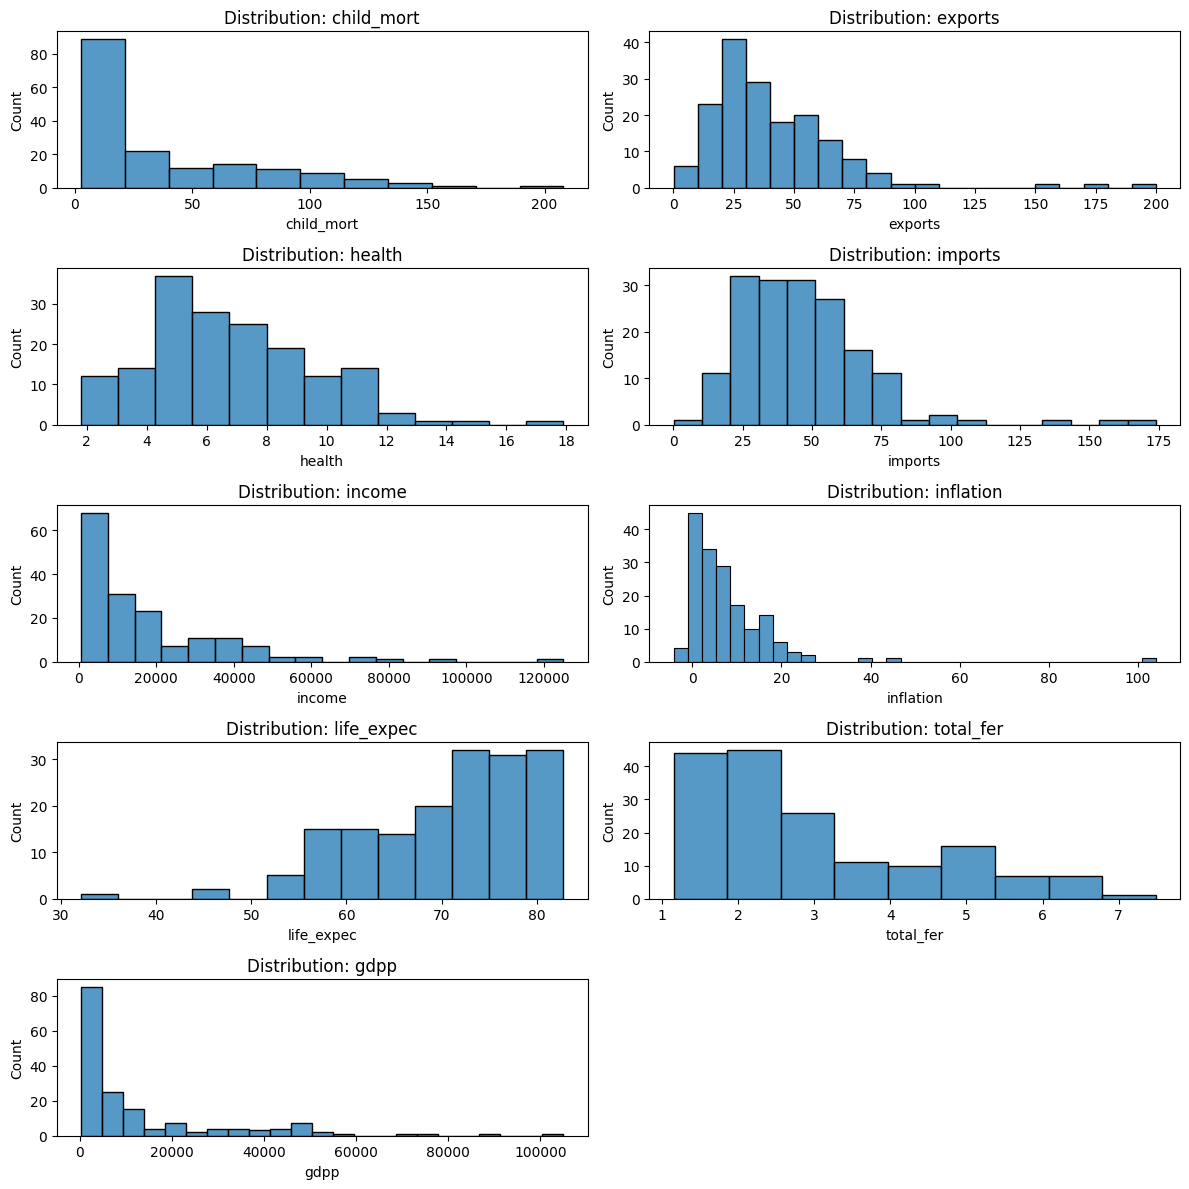

In [9]:
fig, ax = plt.subplots(nrows = 5, ncols = 2, figsize = (12, 12))

# flatten the grid to make it easier to iterate over each subplot
# convert the 2D grid of subplots into a 1D array of subplots, where each element represents a subplot
ax = ax.flatten()

for i, column in enumerate(numerical_columns[ :9]):
    plt.subplot(5, 2, i+1)
    sns.histplot(countries[column])
    plt.title("Distribution: " + column)

# hide the last subplot because it's empty
ax[-1].axis('off')

# prevent overlapping by adjusting the subplots layout
plt.tight_layout()
plt.show()

- There are some outliers, but they may be relevant given the countries with critical values (so this is not noise).

<a id="processing" ></a>
# Pre-processing

<a id="visualization" ></a>
# Data visualization

<a id="pca" ></a>
# Dimensionality reduction (PCA)

<a id="scaling" ></a>
# Scaling

<a id="norm" ></a>
# Normalization 

<a id="ml" ></a>
# K-means clustering